In [1]:
using PyCall
using CSV
using Dates
using Distributions
using DataFrames
using .Threads
using  Plots
using LinearAlgebra


In [2]:
include("Structural Breaks.jl")

SDFC

In [3]:
py"""
import yfinance
import datetime as dt
def get_data():


  data = yfinance.download(tickers="SPY", period="30y", interval="1d")
  return data
"""
df = py"get_data"();

py"""
import pandas as pd
import numpy as np

def get_ohlcv(df_group):
    ohlc = df_group['Close'].ohlc()
    ohlc['volume'] = df_group['Volume'].sum()
    return ohlc

def get_time_bar(df, freq="5Min"):
    df_group = df.groupby(pd.Grouper(freq=freq))
    
    ohlcv = get_ohlcv(df_group).dropna()
    return ohlcv.index , ohlcv.to_numpy()
"""

py"""
def reset_data_time(data):
  df  = data.copy()
  df.set_index(df.index.strftime("%Y-%m-%d"))
  return df
"""

indexs ,ohlcv = py"get_time_bar"(df, freq="1B")
index = indexs.strftime("%Y-%m-%d");
data = DataFrame(Dates = Date.(index,dateformat"y-m-d"),open = ohlcv[:,1] , high = ohlcv[:,2] , low = ohlcv[:,3] , close = ohlcv[:,4] , volume = ohlcv[:,5]);
data = select(data,["Dates" , "close"]);

[*********************100%***********************]  1 of 1 completed


In [7]:
close = copy(data)
close.index = close.Dates
close = close[:,[:index , :close]]
select_ = (close.index .>= Date("2017-04-01")) .& (close.index .<=Date("2021-12-01"))
selectclose = close[select_,:];
selectclose.price = log.(selectclose.close)
selectclose = selectclose[:,[:index , :price]]

,index,price
,Date,Float64
1,2017-04-03,5.46099
2,2017-04-04,5.46163
3,2017-04-05,5.45865
4,2017-04-06,5.46146
5,2017-04-07,5.46044
6,2017-04-10,5.46103
7,2017-04-11,5.45984
8,2017-04-12,5.45545
9,2017-04-13,5.44893


In [8]:
p = ADFTestType(selectclose,100,"nc",40,"SADF")


,index,statistics
,Date,Float64
1,2017-08-23,0.0
2,2017-08-24,0.0
3,2017-08-25,0.0
4,2017-08-28,0.0
5,2017-08-29,0.0
6,2017-08-30,0.0
7,2017-08-31,0.0
8,2017-09-01,0.0
9,2017-09-05,0.0


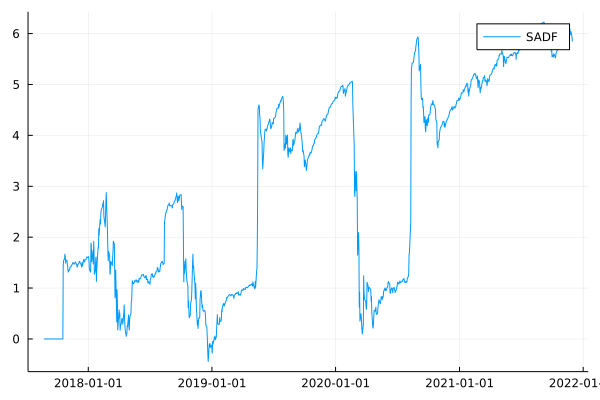

In [12]:
Plots.plot(p.index,p.statistics,label = "SADF")

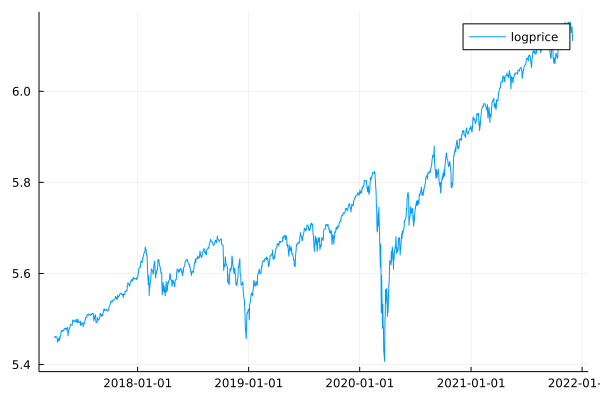

In [11]:
Plots.plot(selectclose.index,selectclose.price,label = "logprice")

In [13]:
close = copy(data)
close.index = close.Dates
close = close[:,[:index , :close]]
select_ = (close.index .>= Date("2004-04-01")) .& (close.index .<=Date("2010-12-01"))
selectclose = close[select_,:];
selectclose.price = log.(selectclose.close)
selectclose = selectclose[:,[:index , :price]];

In [14]:
chow = SDFC(selectclose,selectclose.index[100:(end-100)],0.2,90);

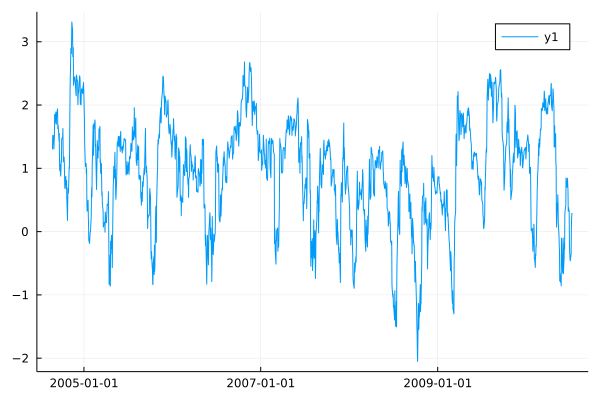

In [15]:
Plots.plot(chow.index,chow.SDFC)

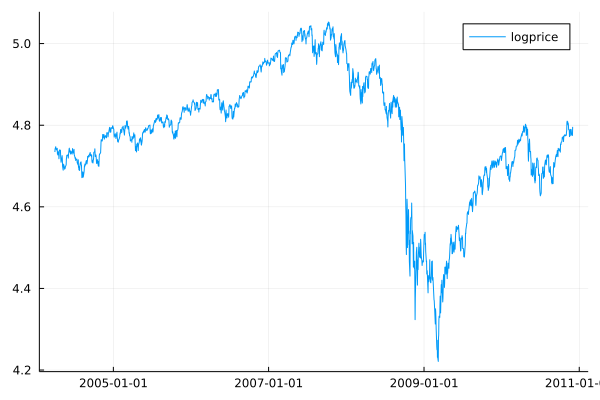

In [16]:
Plots.plot(selectclose.index,selectclose.price,label = "logprice")

In [17]:
chu = ChuStinchcombeWhiteTest(selectclose,"two_sided",selectclose.index[100:(end-100)])

,index,S_n,threshold
,Date,Float64,Float64
1,2004-08-24,1.4744,2.5585
2,2004-08-25,1.70218,2.58446
3,2004-08-26,1.61382,2.62728
4,2004-08-27,1.67353,2.64535
5,2004-08-30,1.27619,2.66175
6,2004-08-31,1.42612,2.67674
7,2004-09-01,1.44921,2.69055
8,2004-09-02,1.78495,2.70334
9,2004-09-03,1.59475,2.71525


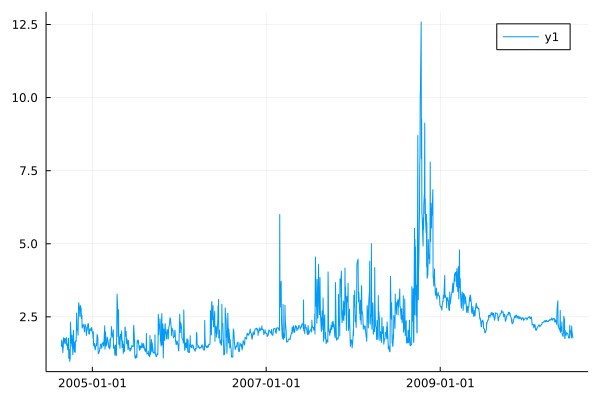

In [18]:
Plots.plot(chu.index,chu.S_n)

In [19]:
close = copy(data)
close.index = close.Dates
close = close[:,[:index , :close]]
select_ = (close.index .>= Date("1990-04-01")) .& (close.index .<=Date("2010-12-01"))
selectclose = close[select_,:];
selectclose.price = log.(selectclose.close)
selectclose = selectclose[:,[:index , :price]]

,index,price
,Date,Float64
1,1993-01-29,3.78277
2,1993-02-01,3.78986
3,1993-02-02,3.79197
4,1993-02-03,3.80249
5,1993-02-04,3.80666
6,1993-02-05,3.80597
7,1993-02-08,3.80597
8,1993-02-09,3.79899
9,1993-02-10,3.80039


In [21]:
X,y = PrepareData(selectclose.price ,"nc", 40);

In [33]:
brown = BrownDurbinEvansTest(X,y,40,100,selectclose.index);

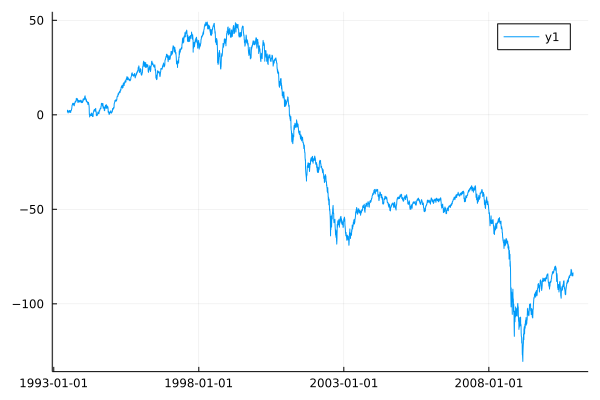

In [34]:
Plots.plot(brown.index,brown.BDECstatistics)

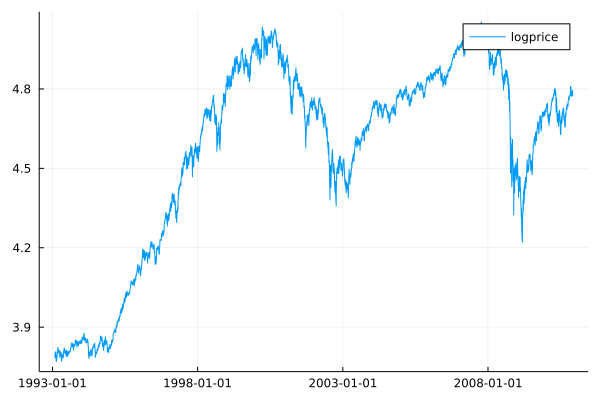

In [24]:
Plots.plot(selectclose.index,selectclose.price,label = "logprice")

In [4]:
using Distributions
d = Normal()
x = rand(d, 1000)
randomwalk=cumsum(x);

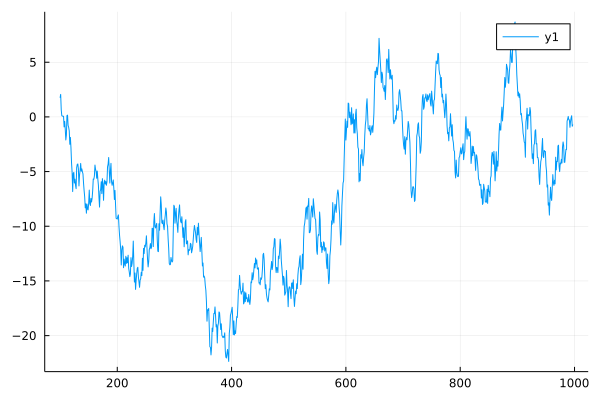

In [5]:
X,y =PrepareData(randomwalk ,"nc", 40)
brown = BrownDurbinEvansTest(X,y,40,100,1:1000)
Plots.plot(brown.index,brown.BDECstatistics)